In [1]:
%matplotlib widget

In [4]:
import numpy as np
np.set_printoptions(linewidth=100)
from joblib import Parallel, delayed
import sympy as sm
import sympy.abc as sbl
from scipy.sparse import diags
from scipy.integrate import RK45, solve_ivp
import scipy.sparse.linalg as la
import scipy.sparse as sp
import time
from functools import lru_cache
import math
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook
from ipywidgets import HBox, IntSlider

plt.ioff()
plt.clf()

In [5]:
class Matrices:
    
    #A *alpha - beta(D *) +beta(E(1 - 0)alpha) = 0
    
    def __init__(self, N=10):
        
        
        self.N = N
        self.shape = (N+1, N+1)
        self.h = 1/N
        self.domain = np.linspace(0, 1, N+1) 
        self.beta = -1
        self.time_step = self.h**2
        self.runs = self.N**2
        
        self.A = (self.h) * sp.csc_matrix(diags([       [1/6 for i in range(N)],   \
                                        [1/3] + [2/3]*(N-1) + [1/3], \
                                             [1/6 for i in range(N)] ], \
                                                   [1, 0, -1]), dtype=np.float32)
        #-
        self.D = (1/self.h) * sp.csr_matrix(diags([      [-1 for i in range(N)],  \
                                      [1] + [2]*(N-1) + [1], \
                                        [-1 for i in range(N)]],  \
                             [1, 0, -1] ), dtype=np.float32)
                #+                
        row = np.array([0, 0, N, N])
        col = np.array([0, 1, N-1, N])
        data = np.array([1, -1, -1, 1 ])
        self.E = (1/self.h) *sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)    
            
     
        
        #Set initial conditions here
        self.alpha = np.sin(np.pi* self.domain).reshape(N+1, 1)
        
        #Set solution here
        self.exact_solution = lambda t: np.sin(np.pi*self.domain).reshape(-1, 1).dot(np.exp(t).reshape(1, -1))
        

    

    
    def matB(self,i):
            if i == 0 :
                row = np.array([0, 0, 1, 1])
                col = np.array([0, 1, 0, 1])
                data = np.array([-1/3, 1/3, -1/6, 1/6])
                return sp.csr_matrix((data, (row, col)), shape=self.shape,dtype=np.float32)        
            elif i == self.N:
                row = np.array([self.N-1, self.N - 1, self.N, self.N])
                col = np.array([self.N-1, self.N , self.N -1, self.N])
                data = np.array([-1/6, 1/6, -1/3, 1/3])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)   
            else:
                row = np.array([i-1]*3 + [i]*3 + [i+1]*3)
                col = np.array([col for col in range(i-1, i+1 + 1)]*3)
                data = np.array([-1/6, 1/6, 0, -1/3, 0, 1/3, 0, -1/6, 1/6 ])
                return sp.csr_matrix((data, (row, col)), shape=self.shape, dtype=np.float32)    
            
   
    


<h3 align="center" style="color:#FFE647;">Equation   </h3> 
\begin{equation}
\\  A \alpha^{'} +\hspace{15mm}\beta ( D \alpha \hspace{10mm} - \hspace{10mm}E \alpha) \hspace{10mm} - \beta F  \alpha \hspace{15mm} = \hspace{15mm}f(t)
\end{equation}


\begin{equation}
\\  \alpha^{'} = -A^{-1}(\beta ( D \alpha  - E \alpha) - \beta F  \alpha - f(t)) \hspace{10mm} (i)
\\  \alpha^{'} = -A^{-1}( \beta ( D \alpha  - E \alpha -  F  \alpha )- f(t)) \hspace{10mm} (i)
\\  \alpha^{'} = -A^{-1}( \beta ( T  \alpha )- f(t)) \hspace{10mm} (i)
\end{equation}



In [6]:

class rk45(Matrices): 
    
    def __init__(self, num_basis = 10):
        
        super().__init__(num_basis)

        self.pos = lambda k,t: ((math.pi**3*self.beta*self.h*math.cos(math.pi*self.h*k) - math.pi**2*self.beta*math.sin(math.pi*self.h*k) + math.pi**2*self.beta*math.sin(math.pi*self.h*(k - 1)) - math.pi*self.h*math.cos(math.pi*self.h*k) + math.sin(math.pi*self.h*k) - math.sin(math.pi*self.h*(k - 1)))*math.exp(t)/(math.pi**2*self.h))
        self.neg = lambda k, t: ((-math.pi**3*self.beta*self.h*math.cos(math.pi*self.h*k) - math.pi**2*self.beta*math.sin(math.pi*self.h*k) + math.pi**2*self.beta*math.sin(math.pi*self.h*(k + 1)) + math.pi*self.h*math.cos(math.pi*self.h*k) + math.sin(math.pi*self.h*k) - math.sin(math.pi*self.h*(k + 1)))*math.exp(t)/(math.pi**2*self.h))
        
        def fun(t, y):
            f_t = (  np.array([0]+[self.pos(k, t) for k in range(1, self.N+1)]) +\
                            np.array([self.neg(k, t) for k in range(0, self.N)]+[0]) \
                            ).reshape(self.N+1, 1) 
            y[0] = 0
            y[-1] = 0
            y = y.reshape(-1, 1)
            return la.inv(self.A).dot(self.beta*(self.D - self.E).dot(y) + f_t)

        self.algo = solve_ivp(fun,t_span=(0, 1),  y0=self.alpha.ravel(), \
            t_eval= [0.5, 1], vectorized=True, max_step = self.h)    

        self.algo.y[[0, -1], :] = 0
        self.approx_half, self.approx_one = np.split(self.algo.y.flatten("F"), len(self.algo.t))  
        self.exact_half, self.exact_one =\
                            np.split(self.exact_solution(self.algo.t).flatten("F"), len(self.algo.t))
        
        self.error_half = math.sqrt(sum((self.approx_half - self.exact_half)**2))
        self.error_one = math.sqrt(sum((self.approx_one - self.exact_one)**2))
        

        self.graph_half = 'plt.plot(self.domain, self.approx_half, self.domain, self.exact_half)'
        
        self.graph_one = 'plt.plot(self.domain, self.approx_one, self.domain, self.exact_one)'

        

In [8]:

errors = []
for i in tqdm_notebook([2**j for j in range(2, 5)]):
    heateqn = rk45(i)
    
    errors.append([

          heateqn.error_half,

         heateqn.error_one,])
    print("Done")
    
    

Done
Done
Done



In [9]:
errors

[[0.09267533346256633, 0.15317430441883445],
 [0.016450866897983613, 0.027211587625426352],
 [0.0025012502586429916, 0.0041344097932173125]]

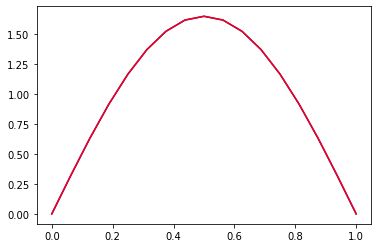

In [10]:
v1 = heateqn.approx_half   #complete it
v2 = heateqn.exact_half  #complete it
plt.plot(heateqn.domain, v1,"b", heateqn.domain, v2 , "r")
plt.show()